## Permian basin case study
### Oxidation --> Electrocoagulation --> Catridge Filtration --> FO --> Deep well injection

### Treatment train (translators included)
<p align=center>
  <img src="/Users/zhuoranzhang/Documents/Github_repos/watertap-reflo/src/watertap_contrib/reflo/analysis/case_studies/permian/assets/FO_DWI.png" width="80%">
</p>

#### Import packages

In [32]:
import pathlib
# Import Pyomo packages
from pyomo.environ import (
    ConcreteModel,
    value,
    TransformationFactory,
    Block,
    check_optimal_termination,
    assert_optimal_termination,
    units as pyunits,
)
from pyomo.network import Arc

# Import IDAES packages
from idaes.core import FlowsheetBlock, UnitModelCostingBlock
import idaes.core.util.scaling as iscale
from idaes.core import MaterialFlowBasis
from idaes.core.util.scaling import (
    calculate_scaling_factors,
)
import idaes.logger as idaeslogger
from idaes.core.util.exceptions import InitializationError
from idaes.models.unit_models import (
    Product,
    Feed,
    Mixer,
    MixingType,
    MomentumMixingType,
)
from idaes.core.util.model_statistics import *
from idaes.core.util.initialization import propagate_state

# Import WaterTAP packages
from watertap.core.solvers import get_solver
from watertap_contrib.reflo.core.wt_reflo_database import REFLODatabase
from watertap.core.zero_order_properties import WaterParameterBlock as ZO
from watertap.core.util.model_diagnostics.infeasible import *
from watertap.core.util.initialization import *
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock

# Import WaterTAP REFLO packages
from watertap_contrib.reflo.costing import (
    TreatmentCosting,
    EnergyCosting,
    REFLOSystemCosting,
)

from watertap_contrib.reflo.analysis.example_flowsheets.fo_trevi_flowsheet import (
    build_fo_trevi_flowsheet,
    fix_dof_and_initialize,
)
from watertap_contrib.reflo.analysis.case_studies.permian import *
from watertap_contrib.reflo.unit_models.deep_well_injection import DeepWellInjection
from watertap_contrib.reflo.property_models.fo_draw_solution_properties import FODrawSolutionParameterBlock

# Global variables
case_study_yaml = f"/Users/zhuoranzhang/Documents/Github_repos/watertap-reflo/src/watertap_contrib/reflo/data/technoeconomic/permian_case_study.yaml"
rho = 1000 * pyunits.kg / pyunits.m**3
solver = get_solver()

#### Create treatment train flowsheet

In [33]:
def build_permian_FO(permian_fo_config):
    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.db = REFLODatabase()

    m.fs.treatment = treat = Block()
    m.fs.energy = energy = Block()

    m.fs.energy.cst = FlowsheetBlock()
    build_cst(m.fs.energy.cst)

    m.fs.properties = ZO(solute_list=["tds"])
    m.fs.properties_feed = SeawaterParameterBlock()
    m.fs.properties_draw = FODrawSolutionParameterBlock()

    treat.feed = Feed(property_package=m.fs.properties)
    treat.product = Product(property_package=m.fs.properties_feed)

    # Add translator blocks
    treat.zo_to_sw_feed = Translator_ZO_to_SW(
        inlet_property_package=m.fs.properties,
        outlet_property_package=m.fs.properties_feed,
    )
    treat.zo_to_sw_ec_disposal = Translator_ZO_to_SW(
        inlet_property_package=m.fs.properties,
        outlet_property_package=m.fs.properties_feed,
    )
    treat.zo_to_sw_cart_filt_disposal = Translator_ZO_to_SW(
        inlet_property_package=m.fs.properties,
        outlet_property_package=m.fs.properties_feed,
    )
    treat.draw_to_sw = Translator_Draw_to_SW(
        inlet_property_package = m.fs.properties_draw,
        outlet_property_package= m.fs.properties_feed,
    )

    # Add components
    treat.chem_addition = FlowsheetBlock(dynamic=False)
    build_chem_addition(m, treat.chem_addition)

    treat.ec = FlowsheetBlock(dynamic=False)
    build_ec(m, treat.ec)

    treat.cart_filt = FlowsheetBlock(dynamic=False)
    build_cartridge_filtration(m, treat.cart_filt)

    treat.FO = build_fo_trevi_flowsheet(feed_vol_flow     =permian_fo_config["feed_vol_flow"], 
                                        feed_TDS_mass     =permian_fo_config["feed_TDS_mass"], 
                                        recovery_ratio    =permian_fo_config["recovery_ratio"],
                                        RO_recovery_ratio =permian_fo_config["RO_recovery_ratio"], 
                                        NF_recovery_ratio =permian_fo_config["NF_recovery_ratio"], 
                                        feed_temperature  =permian_fo_config["feed_temperature"],
                                        strong_draw_temp  =permian_fo_config["strong_draw_temp"],  
                                        strong_draw_mass  =permian_fo_config["strong_draw_mass_frac"],  
                                        )

    treat.DWI = DeepWellInjection(
        property_package=m.fs.properties_feed, injection_well_depth=5000
    )

    treat.disposal_SW_mixer = Mixer(
        property_package=m.fs.properties_feed,
        num_inlets=3,
        inlet_list=["ec_disposal", "cart_filt_disposal", "fo_disposal"],
        energy_mixing_type=MixingType.none,
        momentum_mixing_type=MomentumMixingType.none,
    )

    # BUILD PRODUCT STREAM
    # feed (1)> chem_addition (2)> EC (3)> cart_filt 
    #      (4)> ZO_to_SW_translator (5)> FO (6)> Draw_to_SW_translator (7)> product
    
    treat.feed_to_chem_addition = Arc(
        source=treat.feed.outlet, destination=treat.chem_addition.feed.inlet
    ) # (1)
    treat.chem_addition_to_ec = Arc(
        source=treat.chem_addition.product.outlet, destination=treat.ec.feed.inlet
    ) # (2)
    treat.ec_to_cart_filt = Arc(
        source=treat.ec.product.outlet, destination=treat.cart_filt.feed.inlet
    ) # (3)
    treat.cart_filt_to_translator = Arc(
        source=treat.cart_filt.product.outlet, destination=treat.zo_to_sw_feed.inlet
    ) # (4)
    treat.cart_filt_translated_to_fo = Arc(
        source=treat.zo_to_sw_feed.outlet, destination=treat.FO.fs.fo.feed
    ) # (5)
    treat.fo_to_translator = Arc(
        source=treat.FO.fs.S2.fresh_water, destination=treat.draw_to_sw.inlet
    ) # (6)
    treat.fo_translator_to_product = Arc(
        source=treat.draw_to_sw.outlet, destination=treat.product.inlet
    ) # (7)

    # BUILD DISPOSAL STREAM
    #        EC (1)> ZO_to_SW_translator (3)> disposal_mixer (6)> DWI
    # cart_filt (2)> ZO_to_SW_translator (4)> disposal_mixer
    #                                FO  (5)> disposal_mixer

    treat.ec_disposal_to_translator = Arc(
        source=treat.ec.disposal.outlet, destination=treat.zo_to_sw_ec_disposal.inlet
    ) # (1)
    treat.cart_filt_disposal_to_translator = Arc(
        source=treat.cart_filt.disposal.outlet, destination=treat.zo_to_sw_cart_filt_disposal.inlet,
    ) # (2)
    treat.ec_disposal_translator_to_SW_mixer = Arc(
        source=treat.zo_to_sw_ec_disposal.outlet, destination=treat.disposal_SW_mixer.ec_disposal,
    ) # (3)
    treat.cart_filt_disposal_translator_to_SW_mixer = Arc(
        source=treat.zo_to_sw_cart_filt_disposal.outlet, destination=treat.disposal_SW_mixer.cart_filt_disposal,
    ) # (4)
    treat.fo_disposal_translator_to_SW_mixer = Arc(
        source=treat.FO.fs.fo.brine, destination=treat.disposal_SW_mixer.fo_disposal,
    ) # (5)
    treat.SW_mixer_to_DWI = Arc(
        source=treat.disposal_SW_mixer.outlet, destination=treat.DWI.inlet,
    ) # (6)

    TransformationFactory("network.expand_arcs").apply_to(m)
    
    return m

#### Create functions to customize model configuration

In [34]:
def set_operating_conditions(m, operating_condition, **kwargs):
    Qin, tds = operating_condition["feed_vol_flow"], operating_condition["feed_tds"]

    global flow_mass_water, flow_mass_tds, flow_in

    Qin = Qin * pyunits.Mgallons / pyunits.day
    flow_in = pyunits.convert(Qin, to_units=pyunits.m**3 / pyunits.s)
    flow_mass_water = pyunits.convert(Qin * rho, to_units=pyunits.kg / pyunits.s)
    flow_mass_tds = pyunits.convert(
        Qin * tds * pyunits.g / pyunits.liter, to_units=pyunits.kg / pyunits.s
    )

    m.fs.treatment.feed.properties[0].flow_mass_comp["H2O"].fix(flow_mass_water)
    m.fs.treatment.feed.properties[0].flow_mass_comp["tds"].fix(flow_mass_tds)

    m.fs.treatment.feed.properties[0].conc_mass_comp[...]

    set_chem_addition_op_conditions(m, m.fs.treatment.chem_addition, **kwargs)
    set_ec_operating_conditions(m, m.fs.treatment.ec, **kwargs)
    set_cart_filt_op_conditions(m, m.fs.treatment.cart_filt)

    # Set energy system condition
    set_cst_op_conditions(m.fs.energy.cst)

#### Add functions for scaling and initialization

In [35]:
def set_permian_scaling(m, **kwargs):


    m.fs.properties.set_default_scaling(
        "flow_mass_comp",
        1 / value(flow_mass_water),
        index=("H2O"),
    )

    m.fs.properties.set_default_scaling(
        "flow_mass_comp",
        1 / value(flow_mass_tds),
        index=("tds"),
    )

    m.fs.properties_feed.set_default_scaling(
        "flow_mass_phase_comp",
        1 / value(flow_mass_water),
        index=("Liq", "H2O")
    )
    m.fs.properties_feed.set_default_scaling(
        "flow_mass_phase_comp",
        1 / value(flow_mass_tds),
        index=("Liq", "TDS")
    )

    calculate_scaling_factors(m)


def init_system(m, permian_fo_config):
    treat = m.fs.treatment

    treat.feed.initialize()
    propagate_state(treat.feed_to_chem_addition)   

    init_chem_addition(m, treat.chem_addition)
    propagate_state(treat.chem_addition_to_ec)

    init_ec(m, treat.ec)
    propagate_state(treat.ec_to_cart_filt)
    propagate_state(treat.ec_disposal_to_translator)
    propagate_state(treat.ec_disposal_translator_to_SW_mixer)

    init_cart_filt(m, treat.cart_filt)
    propagate_state(arc = treat.cart_filt_to_translator)
    propagate_state(arc = treat.cart_filt_translated_to_fo)
    propagate_state(treat.cart_filt_disposal_to_translator)
    propagate_state(treat.cart_filt_disposal_translator_to_SW_mixer)

    treat.zo_to_sw_feed.initialize()

    fix_dof_and_initialize(treat.FO,                
                           strong_draw_mass_frac =permian_fo_config["strong_draw_mass_frac"],
                           product_draw_mass_frac=permian_fo_config["product_draw_mass_frac"],
                           RO_recovery_ratio     =permian_fo_config["RO_recovery_ratio"],
                           NF_recovery_ratio     =permian_fo_config["NF_recovery_ratio"],)
    
    # unfix FO fs and set operating point
    treat.FO.fs.HX1.area.unfix()
    treat.FO.fs.HX2.area.unfix()
    treat.FO.fs.HX1.weak_draw_outlet.temperature.fix(permian_fo_config["HX1_cold_out_temp"])
    treat.FO.fs.HX1.product_water_outlet.temperature.fix(permian_fo_config["HX1_hot_out_temp"])

    treat.FO.fs.fo.feed_props[0].flow_mass_phase_comp["Liq", "H2O"].unfix()
    treat.FO.fs.fo.feed_props[0].flow_mass_phase_comp["Liq", "TDS"].unfix()

    propagate_state(arc = treat.fo_to_translator)
    propagate_state(arc = treat.fo_translator_to_product)
    propagate_state(arc = treat.fo_disposal_translator_to_SW_mixer)

    treat.product.initialize()

    treat.zo_to_sw_ec_disposal.outlet.temperature[0].fix(25 + 273.15)
    treat.zo_to_sw_ec_disposal.outlet.pressure[0].fix(101325)
    treat.zo_to_sw_cart_filt_disposal.outlet.temperature[0].fix(25 + 273.15)
    treat.zo_to_sw_cart_filt_disposal.outlet.pressure[0].fix(101325)
    treat.FO.fs.fo.brine.pressure[0].fix(101325)

    treat.zo_to_sw_ec_disposal.initialize()
    treat.zo_to_sw_cart_filt_disposal.initialize()
    
    treat.disposal_SW_mixer.initialize()
    propagate_state(arc = treat.SW_mixer_to_DWI)

    treat.DWI.properties[0].temperature.fix()
    treat.DWI.properties[0].pressure.fix()
    treat.DWI.initialize()

    init_cst(m.fs.energy.cst)


#### Add functions to incorporate costing models

In [36]:

def add_treatment_costing(m):

    m.fs.treatment.costing = TreatmentCosting(case_study_definition=case_study_yaml)
    add_chem_addition_costing(
        m, m.fs.treatment.chem_addition, flowsheet_costing_block=m.fs.treatment.costing
    )

    add_ec_costing(m, m.fs.treatment.ec, flowsheet_costing_block=m.fs.treatment.costing)

    add_cartridge_filtration_costing(
        m, m.fs.treatment.cart_filt, flowsheet_costing_block=m.fs.treatment.costing
    )

    m.fs.treatment.FO.fs.fo.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.treatment.costing)
    
    m.fs.treatment.DWI.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.treatment.costing)

    m.fs.treatment.costing.cost_process()

def add_energy_costing(m):
    energy = m.fs.energy
    energy.costing = EnergyCosting()

    # energy.costing.base_currency = pyunits.USD_2023
    energy.cst.unit.costing = UnitModelCostingBlock(
        flowsheet_costing_block=energy.costing,
    )

    energy.costing.heat_cost.set_value(0)
    energy.costing.cost_process()
    energy.costing.add_LCOH()
    energy.costing.initialize()


    energy.cst.unit.heat_load.unfix()
    energy.costing.aggregate_flow_heat.fix(-150000)

#### Streamline the model setup, initialization and execution

In [39]:
def run_permian_FO(operating_condition,
                   permian_fo_config):
    m = build_permian_FO(permian_fo_config)
    treat = m.fs.treatment

    set_operating_conditions(m, operating_condition)
    set_permian_scaling(m)

    treat.feed.properties[0].flow_vol

    init_system(m, permian_fo_config)

    print('DOF after init: ', degrees_of_freedom(m))
    results = solver.solve(m)
    assert_optimal_termination(results)

    add_treatment_costing(m)
    add_energy_costing(m)

    flow_vol = treat.product.properties[0].flow_vol_phase["Liq"]
    treat.costing.base_currency = pyunits.USD_2023
    treat.costing.electricity_cost.fix(0.07)
    treat.costing.heat_cost.fix(0.02)
    treat.costing.add_LCOW(flow_vol)
    treat.costing.add_specific_energy_consumption(flow_vol, name="SEC")
    treat.costing.initialize()

    results = solver.solve(m)
    assert_optimal_termination(results)

    return m

### Case Study for Permian basin
#### Feed flow rate: 5 MGD
#### Feed salinity: 130 g/L

In [40]:
# FO model configurations
permian_fo_config = {
"feed_vol_flow": 0.22, # initial value for fo model setup
"feed_TDS_mass": 0.119, # mass fraction, 0.119 is about 130 g/L
"recovery_ratio": 0.44,
"RO_recovery_ratio":1,  # RO recovery ratio
"NF_recovery_ratio":0.8,  # Nanofiltration recovery ratio
"feed_temperature":25,
"strong_draw_temp":25,  # Strong draw solution inlet temperature (C)
"strong_draw_mass_frac":0.9,  # Strong draw solution mass fraction
"product_draw_mass_frac": 0.01,   # FO product draw solution mass fraction
"HX1_cold_out_temp": 78 + 273.15, # HX1 coldside outlet temperature
"HX1_hot_out_temp": 32 + 273.15,  # HX1 hotside outlet temperature
}

operating_condition = {
"feed_vol_flow": 5, # MGD
"feed_tds": 130 # g/L
}

m = run_permian_FO(operating_condition,
                    permian_fo_config,
                    )


           =======> BUILDING CST SYSTEM <=======            

2025-01-27 16:55:25 [INFO] idaes.fs.energy.cst.unit: Loading surrogate.
2025-01-27 16:55:25 [INFO] idaes.core.surrogate.pysmo_surrogate: Decode surrogate. type=rbf

    =======> BUILDING CHEMICAL ADDITION SYSTEM <=======     


            =======> BUILDING EC SYSTEM <=======            


   =======> BUILDING CARTRIDGE FILTRATION SYSTEM <=======   

2025-01-27 16:55:25 [INFO] idaes.init.fs.fo.strong_draw_props: State Released.
2025-01-27 16:55:25 [WARNING] idaes.watertap_contrib.reflo.property_models.fo_draw_solution_properties: While using the calculate_state method on fs.fo.strong_draw_props[0.0], variable flow_vol_phase was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or se

/Users/zhuoranzhang/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


2025-01-27 16:55:25 [INFO] idaes.init.fs.fo.feed_props: fs.fo.feed_props State Released.
2025-01-27 16:55:25 [WARNING] idaes.watertap.property_models.seawater_prop_pack: While using the calculate_state method on fs.fo.feed_props[0.0], variable flow_vol_phase was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or set an initial value) before using the calculate_scaling_factor method.
2025-01-27 16:55:25 [WARNING] idaes.watertap.property_models.seawater_prop_pack: While using the calculate_state method on fs.fo.feed_props[0.0], variable mass_frac_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand

#### Collect results for cost breakdown

In [48]:
# Retrieve costing numbers for each compononet
lcow = value(m.fs.treatment.costing.LCOW)
capex_total = value(m.fs.treatment.costing.total_capital_cost)
chem_capex = m.fs.treatment.chem_addition.unit.costing.capital_cost()
filt_capex = m.fs.treatment.cart_filt.unit.costing.capital_cost()
ec_capex = m.fs.treatment.ec.unit.costing.capital_cost()
fo_capex = m.fs.treatment.FO.fs.fo.costing.capital_cost()
dwi_capex = m.fs.treatment.DWI.costing.capital_cost()

opex_total = value(m.fs.treatment.costing.total_operating_cost)
fix_opex = value(m.fs.treatment.costing.maintenance_labor_chemical_operating_cost)
chem_opex = chem_capex * 0.03
filt_opex = filt_capex * 0.03
ec_opex = ec_capex * 0.03
fo_opex = fo_capex * 0.03
dwi_opex = dwi_capex * 0.03

var_opex_total = value(m.fs.treatment.costing.total_variable_operating_cost)
elec_cost = value(m.fs.treatment.costing.aggregate_flow_costs["electricity"])
heat_cost = value(m.fs.treatment.costing.aggregate_flow_costs["heat"])
alum_cost = value(m.fs.treatment.costing.aggregate_flow_costs["aluminum"])
h2o2_cost = value(m.fs.treatment.costing.aggregate_flow_costs["hydrogen_peroxide"])


chem_elec_cost = 0.07 * value(m.fs.treatment.chem_addition.unit.electricity[0]) * 10290.711324821756
ec_elec_cost = 0.07 * value(m.fs.treatment.ec.unit.costing.electricity_flow) * 10290.711324821756
filt_elec_cost = 0.07 * value(m.fs.treatment.cart_filt.unit.electricity[0]) * 10290.711324821756
fo_elec_cost = 0.07 * value(m.fs.treatment.FO.fs.fo.costing.electricity_flow) * 10290.711324821756
fo_heat_cost = 0.02 * value(m.fs.treatment.FO.fs.fo.costing.thermal_energy_flow) * 8766
dwi_elec_cost = 0.07 * value(m.fs.treatment.DWI.costing.pumping_power_required) * 10290.711324821756


print('LCOW                     ', round(lcow,2))

print('TOTAL CAPEX              ', round(capex_total,2))
print('    Chem_addition capex     ', round(chem_capex,2))
print('    Elec_coag capex      ', round(ec_capex,2))
print('    Cart_filtration capex ', round(filt_capex,2))
print('    FO capex              ', round(fo_capex,2))
print('    DWI capex             ', round(dwi_capex,2))
print('')

print('TOTAL OPEX               ', round(opex_total,2))
print('     Total FIXED OPEX     ', round(fix_opex,2))
print('           Chem_opex         ', round(chem_opex,2))
print('           Filt_opex        ', round(filt_opex,2))
print('           EC_opex         ', round(ec_opex,2))
print('           FO_opex         ', round(fo_opex,2))
print('           DWI_opex        ', round(dwi_opex,2))
print('')
print('     TOTAL VAR OPEX      ', round(var_opex_total,2))
print('           Elec cost      ', round(elec_cost,2))
print('           Heat cost      ', round(heat_cost,2))
print('           Al cost       ', round(alum_cost,2))
print('           H2O2 cost       ', round(h2o2_cost,2))

LCOW                      9.75
TOTAL CAPEX               37172959.28
    Chem_addition capex      47741.84
    Elec_coag capex       19966714.86
    Cart_filtration capex  2625088.91
    FO capex               5260221.35
    DWI capex              9273192.32

TOTAL OPEX                25486213.31
     Total FIXED OPEX      1115188.78
           Chem_opex          1432.26
           Filt_opex         78752.67
           EC_opex          599001.45
           FO_opex          157806.64
           DWI_opex         278195.77

     TOTAL VAR OPEX       24371024.54
           Elec cost       5321928.34
           Heat cost       1468798.96
           Al cost        17420341.53
           H2O2 cost        159955.7


In [ ]:
def parametric_sweep_of_recovery_rate():   # --> Cost breakdowns 
    chem_capexs = []
    ec_capexs = []
    filt_capexs = []
    fo_capexs = []
    dwi_capexs = []

    chem_opexs =[]
    ec_opexs = []
    filt_opexs = []
    fo_opexs = []
    dwi_opexs = []

    elecs = []
    heats = []
    alums = []
    h2o2s = []

    LCOWs =[]
    failed= []

    rr = [ 0.21,0.24,0.28,0.32,0.35,0.4,0.44, ]
    strong_draw_mass = [i*0.03 + 0.80 for i in range(6)]

    for v in rr:
        permian_fo_config = {
    "feed_vol_flow": 0.22, # initial value for fo model setup
    "feed_TDS_mass": 0.119, # mass fraction, 0.119 is about 130 g/L
    "recovery_ratio": v,
    "RO_recovery_ratio":1,  # RO recovery ratio
    "NF_recovery_ratio":0.8,  # Nanofiltration recovery ratio
    "feed_temperature":25,
    "strong_draw_temp":25,  # Strong draw solution inlet temperature (C)
    "strong_draw_mass_frac": 0.9,  # Strong draw solution mass fraction
    "product_draw_mass_frac": 0.01,   # FO product draw solution mass fraction
    "HX1_cold_out_temp": 78 + 273.15, # HX1 coldside outlet temperature
    "HX1_hot_out_temp": 32 + 273.15,  # HX1 hotside outlet temperature
    }
        operating_condition = {
    "feed_vol_flow": 5, # MGD
    "feed_tds": 130 # g/L
    }
        try:
            m = run_permian_FO(operating_condition,
                        permian_fo_config,
                        )
        except:
            failed.append(v)
            continue

        lcow = value(m.fs.treatment.costing.LCOW)
        capex_total = value(m.fs.treatment.costing.total_capital_cost)
        chem_capex = m.fs.treatment.chem_addition.unit.costing.capital_cost()
        filt_capex = m.fs.treatment.cart_filt.unit.costing.capital_cost()
        ec_capex = m.fs.treatment.ec.unit.costing.capital_cost()
        fo_capex = m.fs.treatment.FO.fs.fo.costing.capital_cost()
        dwi_capex = m.fs.treatment.DWI.costing.capital_cost()

        opex_total = value(m.fs.treatment.costing.total_operating_cost)
        fix_opex = value(m.fs.treatment.costing.maintenance_labor_chemical_operating_cost)
        chem_opex = chem_capex * 0.03
        filt_opex = filt_capex * 0.03
        ec_opex = ec_capex * 0.03
        fo_opex = fo_capex * 0.03
        dwi_opex = dwi_capex * 0.03

        # fo_elec_cost = 0.07 * value(m.fs.treatment.FO.fs.fo.costing.electricity_flow) * 10290.711324821756
        fo_heat_cost = 0.02 * value(m.fs.treatment.FO.fs.fo.costing.thermal_energy_flow) * 8766
        chem_elec_cost = 0.07 * 10290.711324821756 * value(m.fs.treatment.costing._registered_flows["electricity"][0])
        ec_elec_cost = 0.07 * 10290.711324821756 * value(m.fs.treatment.costing._registered_flows["electricity"][1])
        filt_elec_cost = 0.07 * 10290.711324821756 * value(m.fs.treatment.costing._registered_flows["electricity"][2])
        fo_elec_cost = 0.07 * 10290.711324821756 * value(m.fs.treatment.costing._registered_flows["electricity"][3])
        dwi_elec_cost = 0.07 * 10290.711324821756 * value(m.fs.treatment.costing._registered_flows["electricity"][4])


        var_opex_total = value(m.fs.treatment.costing.total_variable_operating_cost)
        elec_cost = value(m.fs.treatment.costing.aggregate_flow_costs["electricity"])
        heat_cost = value(m.fs.treatment.costing.aggregate_flow_costs["heat"])
        alum_cost = value(m.fs.treatment.costing.aggregate_flow_costs["aluminum"])
        h2o2_cost = value(m.fs.treatment.costing.aggregate_flow_costs["hydrogen_peroxide"])

        capital_recovery_rate = value(m.fs.treatment.costing.capital_recovery_factor)
        flow_vol = value(pyunits.convert(m.fs.treatment.product.properties[0].flow_vol_phase["Liq"],
                                         to_units=pyunits.m**3/pyunits.year))

        LCOWs.append(lcow)
        chem_capexs.append(chem_capex*capital_recovery_rate/flow_vol)
        ec_capexs.append(ec_capex*capital_recovery_rate/flow_vol)
        filt_capexs.append(filt_capex*capital_recovery_rate/flow_vol)
        fo_capexs.append(fo_capex*capital_recovery_rate/flow_vol)
        dwi_capexs.append(dwi_capex*capital_recovery_rate/flow_vol)

        chem_opexs.append((chem_opex ) /flow_vol)
        ec_opexs.append(  (ec_opex   ) /flow_vol)
        filt_opexs.append((filt_opex )/flow_vol)
        fo_opexs.append(  (fo_opex  ) /flow_vol)
        dwi_opexs.append( (dwi_opex ) /flow_vol)

        elecs.append(elec_cost/flow_vol)
        heats.append(heat_cost/flow_vol)
        alums.append(alum_cost/flow_vol)
        h2o2s.append(h2o2_cost/flow_vol)

    cost_breakdowns = [rr,
                chem_capexs, chem_opexs,
                ec_capexs, ec_opexs,
                filt_capexs, filt_opexs,
                fo_capexs, fo_opexs,
                dwi_capexs, dwi_opexs]

    return cost_breakdowns


cost_breakdowns = parametric_sweep_of_recovery_rate()

#### Plot the parametric analysis results

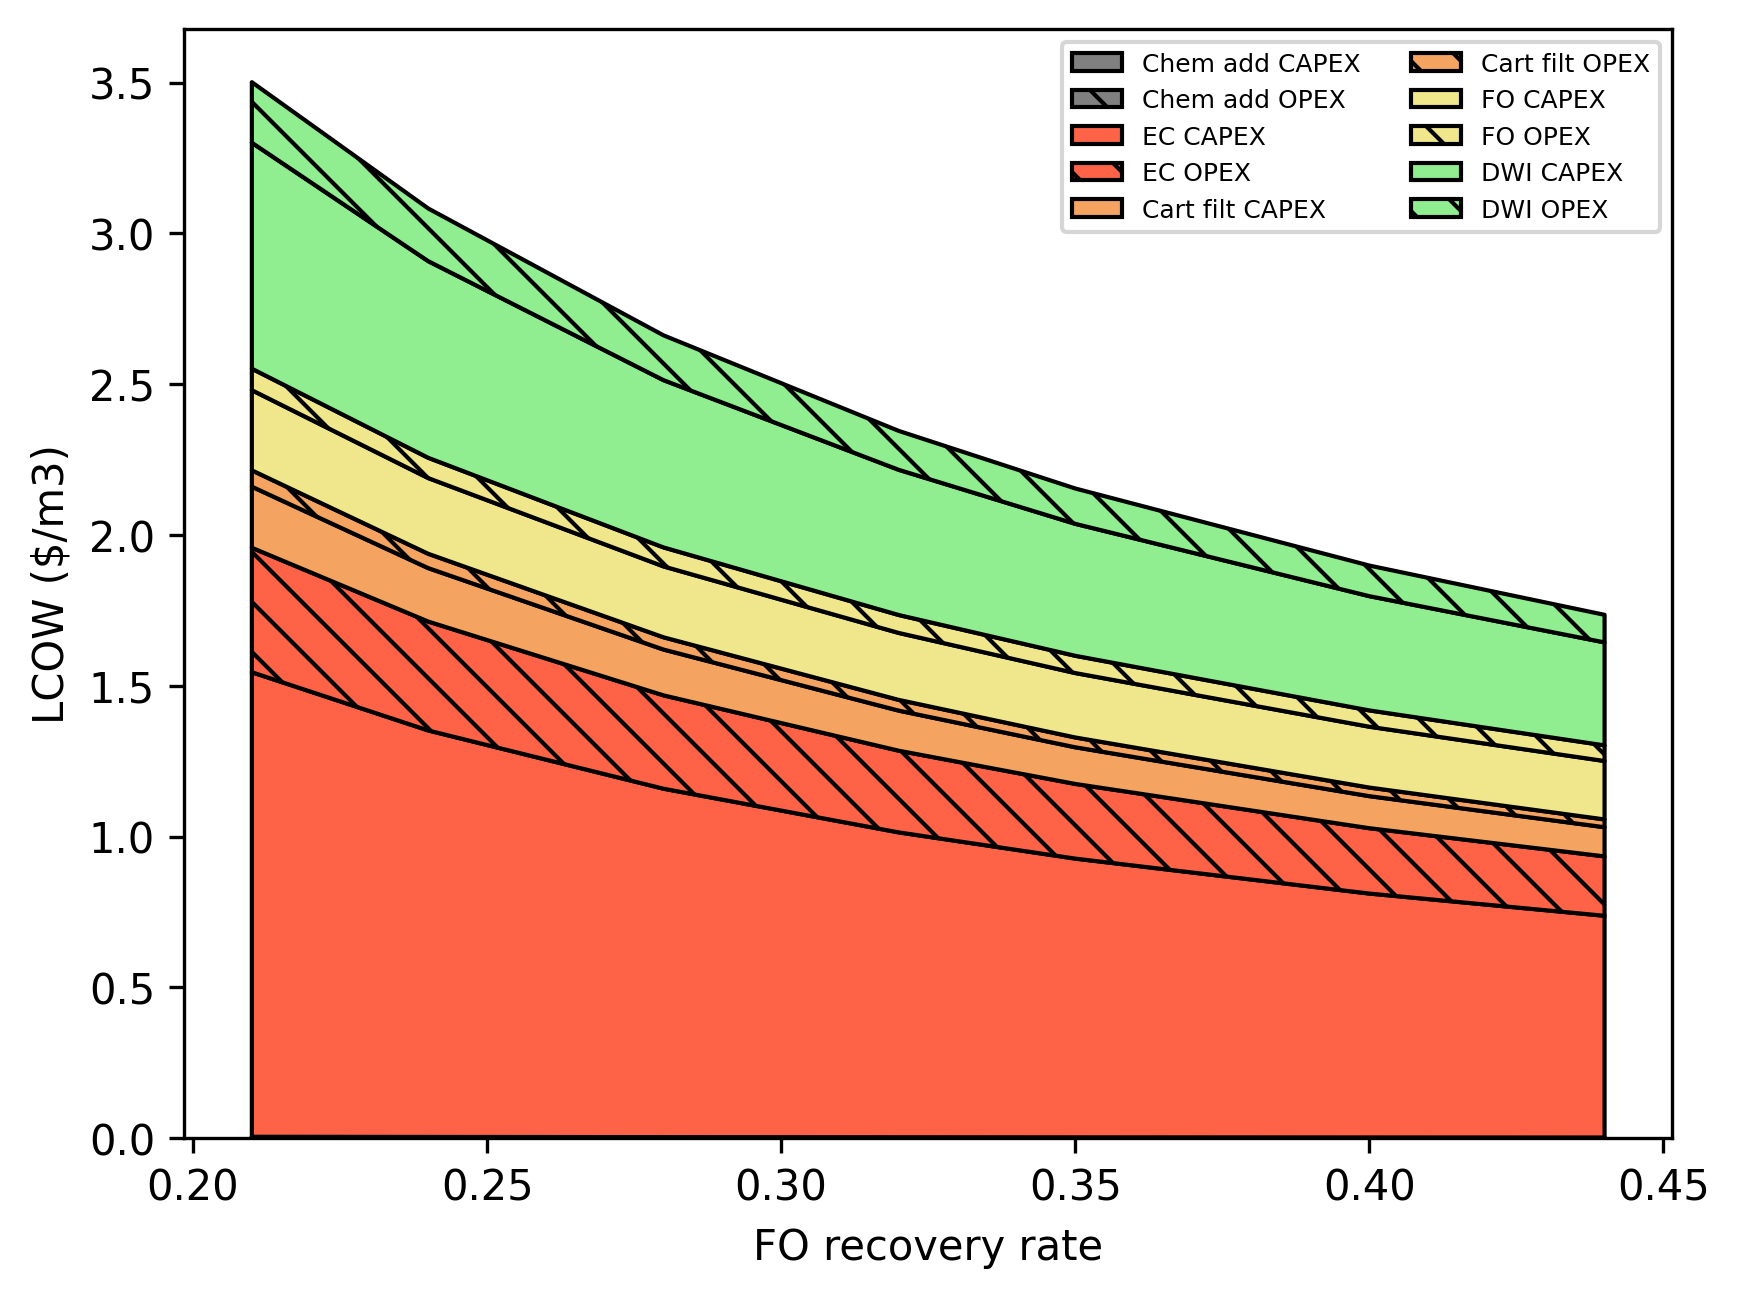

In [52]:
# Get cost breakdowns
(rr, chem_capexs, chem_opexs, ec_capexs, ec_opexs,filt_capexs,
filt_opexs,fo_capexs, fo_opexs, dwi_capexs, dwi_opexs) = cost_breakdowns


import matplotlib.pyplot as plt
plt.stackplot(rr,
            chem_capexs, chem_opexs,
            ec_capexs, ec_opexs,
            filt_capexs, filt_opexs,
            fo_capexs, fo_opexs,
            dwi_capexs, dwi_opexs,
            # elecs, heats, alums, h2o2s,
            labels=['Chem add CAPEX', 'Chem add OPEX',
                    'EC CAPEX', 'EC OPEX',
                    'Cart filt CAPEX', 'Cart filt OPEX',
                    'FO CAPEX', 'FO OPEX',
                    'DWI CAPEX', 'DWI OPEX',
                    # 'Elec', 'Heat','Aluminum','H2O2'
                    ],
            hatch =['', '\\\\',
                    '', '\\\\',
                    '', '\\\\',
                    '', '\\\\',
                    '', '\\\\',
                    '','','','',
                    ],
            colors=['gray','gray',
                    'tomato', 'tomato',
                    'sandybrown','sandybrown',
                    'khaki','khaki',
                    'lightgreen','lightgreen',
                    # 'gold','indianred','royalblue','darkviolet'
                    ],
            edgecolor='black',
                    )

plt.rcParams['figure.dpi']=300

# Show the legend
plt.legend(loc='upper right', ncol =2,prop={'size': 6})

plt.ylabel('LCOW ($/m3)')
plt.xlabel('FO recovery rate')
plt.title('')
# Display the chart
plt.show()